**Chapter 15 – Processing Sequences Using RNNs and CNNs**

_This notebook contains all the sample code in chapter 15._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures

#server:
#PROJECT_ROOT_DIR = "/home/arto/MLWork/Geron"
#MBP:
PROJECT_ROOT_DIR = "/Users/arto/Documents/MLWork/Geron"


CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# Basic RNNs

### Generate the Dataset

In [8]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

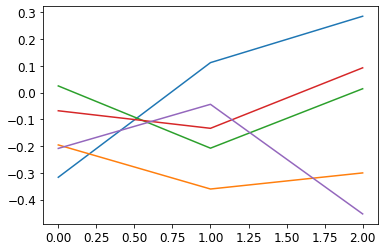

In [9]:
plt.plot(np.random.rand(3, 5)-0.5)

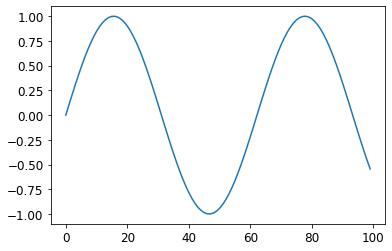

In [10]:
plt.plot(np.sin((np.linspace(0,10,100))))

In [11]:
plt.plot(X_train[44,:,0])

NameError: name 'X_train' is not defined

In [12]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [13]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


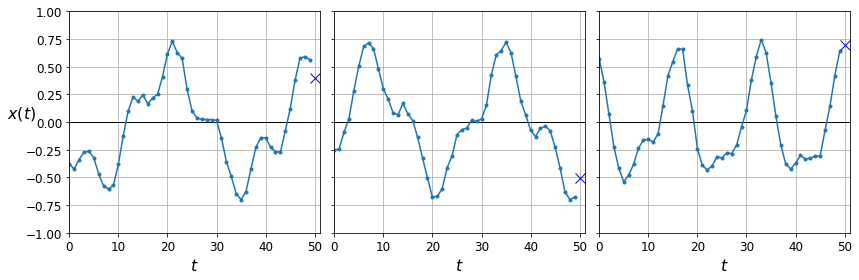

In [14]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

My comment: X_train contains 7000 time series, whose length is 50.

In [15]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

In [16]:
print(y_valid)
print(y_valid.shape)

[[ 0.4000832 ]
 [-0.50259125]
 [ 0.69304645]
 ...
 [-0.25712416]
 [-0.2791788 ]
 [ 0.6290542 ]]
(2000, 1)


In [17]:
print(y_pred)

[[ 0.5643068 ]
 [-0.6759614 ]
 [ 0.64214784]
 ...
 [-0.19055651]
 [-0.1811238 ]
 [ 0.42333305]]


In [18]:
print(X_valid[:,-1])
print(X_valid[:,-1].shape)

[[ 0.5643068 ]
 [-0.6759614 ]
 [ 0.64214784]
 ...
 [-0.19055651]
 [-0.1811238 ]
 [ 0.42333305]]
(2000, 1)


In [19]:
print(y_valid[0,0])
print(y_pred[0,0])

0.4000832
0.5643068


My comment: this is a plot of one of thousands of time series.


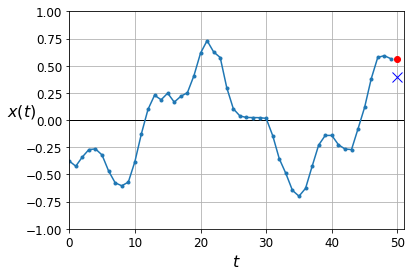

In [20]:
plot_series(X_valid[0, :,0], y_valid[0, 0], y_pred[0, 0])
plt.show()

My addition: two more time series plots. The second X time series, and the last one.

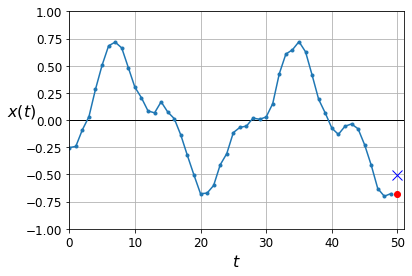

In [21]:
plot_series(X_valid[1, :,0], y_valid[1, 0], y_pred[1, 0])
plt.show()

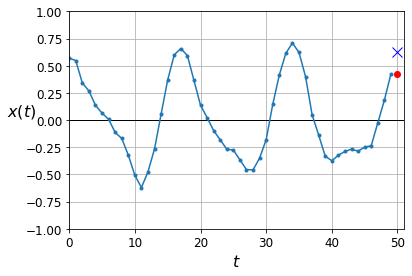

In [22]:
plot_series(X_valid[-1, :,0], y_valid[-1, 0], y_pred[-1, 0])
plt.show()

Linear predictions:

In [23]:
X_train.shape


(7000, 50, 1)

In [24]:
X_valid.shape

(2000, 50, 1)

My comment: 
A simple fully connected network. It expects a flat list of inputs - therefore the Flatten command.

In [25]:
print(X_train.shape)
print(y_train.shape)

(7000, 50, 1)
(7000, 1)


My comment: Flatten determines the output shape.
The Dense layer implements the operation: 
output = activation(dot(input, kernel) + bias)

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?version=stable

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 1s 159us/sample - loss: 0.1008 - val_loss: 0.0552
Epoch 2/5
7000/7000 [==============================] - 0s 57us/sample - loss: 0.0388 - val_loss: 0.0270
Epoch 3/5
7000/7000 [==============================] - 0s 56us/sample - loss: 0.0206 - val_loss: 0.0160
Epoch 4/5
7000/7000 [==============================] - 0s 55us/sample - loss: 0.0132 - val_loss: 0.0115
Epoch 5/5
7000/7000 [==============================] - 0s 59us/sample - loss: 0.0103 - val_loss: 0.0097


In [27]:
model.evaluate(X_valid, y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.00971375086903572

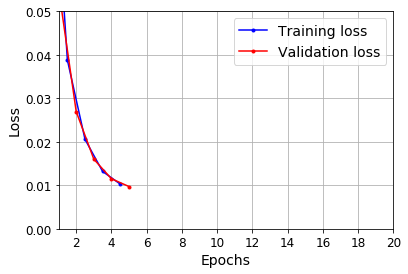

In [28]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [29]:
history.history

{'loss': [0.10078273459417479,
  0.038808882244995666,
  0.020572018403027737,
  0.0131864938597594,
  0.010277770198881627],
 'val_loss': [0.05522795021533966,
  0.026964735358953475,
  0.016012486264109612,
  0.011511048190295697,
  0.00971375086903572]}

In [30]:
history.params

{'batch_size': 32,
 'epochs': 5,
 'steps': 219,
 'samples': 7000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'val_loss']}

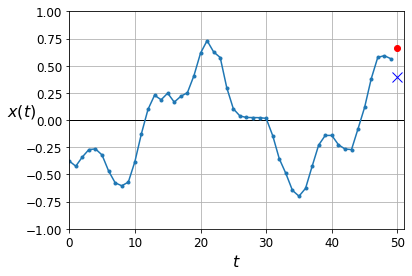

In [31]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using a Simple RNN

https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN?version=stable

Simplest possible RNN. Single neuron. single layer.

From the book:

Default activation: $\tanh$. 

$h_{(init)} = 0$

$x_(0)$ is the first time step.

Neuron computes a weighted sum, applies the tanh activation; this give the first output $y_0$.

SimpleRNN: the output is also the new state h_0.

$h_0$ and $x_1$ are passed to the same recurrent neuron.
The last layer is $y_{49}$.

All this is performed simultaneously for all 7000 time series.


In [32]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=6,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/6
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0979 - val_loss: 0.0490
Epoch 2/6
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0371 - val_loss: 0.0297
Epoch 3/6
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0254 - val_loss: 0.0219
Epoch 4/6
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0199 - val_loss: 0.0177
Epoch 5/6
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0166 - val_loss: 0.0151
Epoch 6/6
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0146 - val_loss: 0.0135


In [33]:
model.evaluate(X_valid, y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.01347692620754242

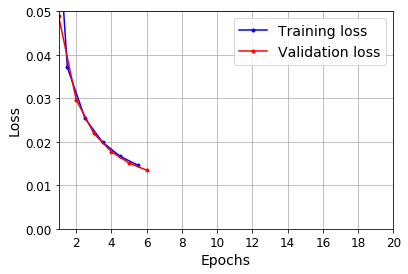

In [34]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

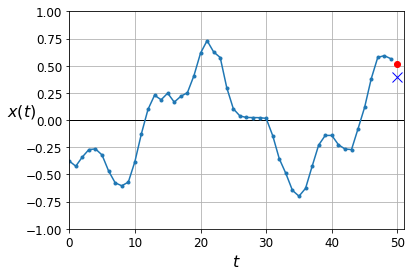

In [35]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [36]:
print(X_train.shape)
print(y_train.shape)

(7000, 50, 1)
(7000, 1)


In [37]:
X_train[:10,1]

array([[ 0.31486678],
       [ 0.23174433],
       [ 0.36084807],
       [ 0.39868876],
       [ 0.53600854],
       [-0.5301287 ],
       [ 0.4150561 ],
       [-0.4785005 ],
       [ 0.684429  ],
       [ 0.3450004 ]], dtype=float32)

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 32s 5ms/sample - loss: 0.0531 - val_loss: 0.0083
Epoch 2/5
7000/7000 [==============================] - 25s 4ms/sample - loss: 0.0074 - val_loss: 0.0055
Epoch 3/5
7000/7000 [==============================] - 25s 4ms/sample - loss: 0.0054 - val_loss: 0.0050
Epoch 4/5
7000/7000 [==============================] - 28s 4ms/sample - loss: 0.0047 - val_loss: 0.0041
Epoch 5/5
7000/7000 [==============================] - 25s 4ms/sample - loss: 0.0044 - val_loss: 0.0041


In [17]:
model.evaluate(X_valid, y_valid)

2000/2000 [==============================] - 1s 567us/sample - loss: 0.0029


0.002889613825827837

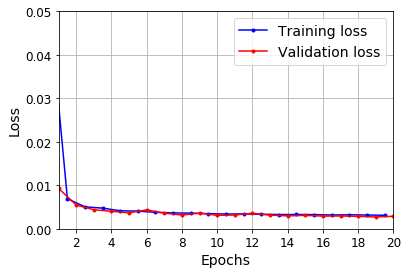

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

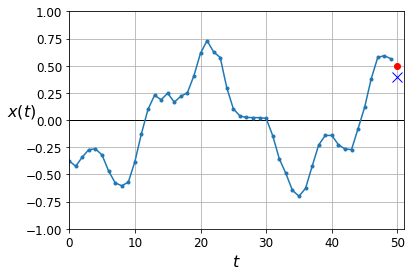

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

Make the second `SimpleRNN` layer return only the last output:

My comment:

In the above model, the output is a single unit, meaning that the hidden layer is also a single number. Not very useful.

tanh values -1 to 1. 
Replace 
 keras.layers.SimpleRNN(1)

with 
keras.layers.Dense(1)

Now able use any activation we want.


In [39]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=6,
                    validation_data=(X_valid, y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/6
7000/7000 [==============================] - 25s 4ms/sample - loss: 0.0240 - val_loss: 0.0050
Epoch 2/6
7000/7000 [==============================] - 19s 3ms/sample - loss: 0.0043 - val_loss: 0.0035
Epoch 3/6
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0036 - val_loss: 0.0033
Epoch 4/6
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0034 - val_loss: 0.0032
Epoch 5/6
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0032 - val_loss: 0.0030
Epoch 6/6
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0032 - val_loss: 0.0034


In [40]:
model.evaluate(X_valid, y_valid)

2000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0033729767436161636

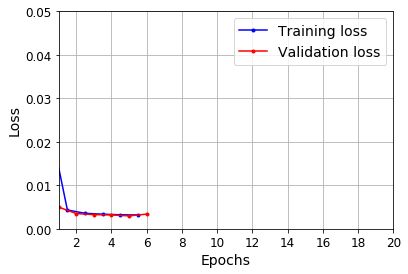

In [41]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

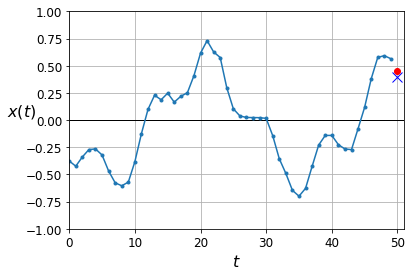

In [42]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Forecasting Several Steps Ahead

My comment:
use the existing model, make it predict the next value, the then use the model again, and so on.

In [43]:
for i in range(3):
    print(i)

0
1
2


In [44]:
n_steps

50

In [45]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
print(X_new.shape, Y_new.shape)
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    print(X[:,step_ahead:].shape)
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

(1, 50, 1) (1, 10, 1)
(1, 50, 1)
(1, 50, 1)
(1, 50, 1)
(1, 50, 1)
(1, 50, 1)
(1, 50, 1)
(1, 50, 1)
(1, 50, 1)
(1, 50, 1)
(1, 50, 1)


In [46]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


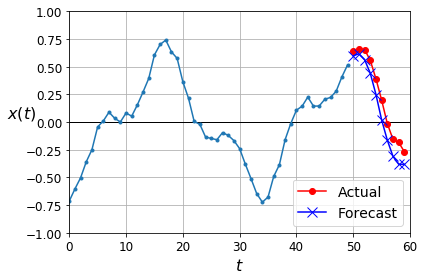

In [47]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

Now let's use this model to predict the next 10 values. We first need to regenerate the sequences with 9 more time steps.

In [48]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

Now let's predict the next 10 values one by one:

In [55]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 1 and the array at index 1 has size 10

Note: Y_pred has 10 rows!

In [ ]:
Y_pred.shape

In [51]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.033579085

Let's compare this performance with some baselines: naive predictions and a simple linear model:

In [52]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=10,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/10
7000/7000 [==============================] - 1s 131us/sample - loss: 0.1335 - val_loss: 0.0605
Epoch 2/10
7000/7000 [==============================] - 0s 63us/sample - loss: 0.0498 - val_loss: 0.0424
Epoch 3/10
7000/7000 [==============================] - 0s 63us/sample - loss: 0.0385 - val_loss: 0.0354
Epoch 4/10
7000/7000 [==============================] - 0s 63us/sample - loss: 0.0332 - val_loss: 0.0313
Epoch 5/10
7000/7000 [==============================] - 0s 63us/sample - loss: 0.0298 - val_loss: 0.0282
Epoch 6/10
7000/7000 [==============================] - 0s 62us/sample - loss: 0.0274 - val_loss: 0.0264
Epoch 7/10
7000/7000 [==============================] - 0s 65us/sample - loss: 0.0257 - val_loss: 0.0249
Epoch 8/10
7000/7000 [==============================] - 0s 63us/sample - loss: 0.0244 - val_loss: 0.0240
Epoch 9/10
7000/7000 [==============================] - 0s 63us/sample - loss: 0.0235 - val_loss: 0.0229
Epoch 

Now let's create an RNN that predicts all 10 next values at once:

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 23s 3ms/sample - loss: 0.0663 - val_loss: 0.0312
Epoch 2/20
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0265 - val_loss: 0.0214
Epoch 3/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0187 - val_loss: 0.0203
Epoch 4/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0151 - val_loss: 0.0157
Epoch 5/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0139 - val_loss: 0.0127
Epoch 6/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0127 - val_loss: 0.0114
Epoch 7/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0119 - val_loss: 0.0118
Epoch 8/20
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0114 - val_loss: 0.0106
Epoch 9/20
7000/7000 [==============================] - 18s 3ms/sample - loss: 0.0110 - val_loss: 0.0116
Epoch 1

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

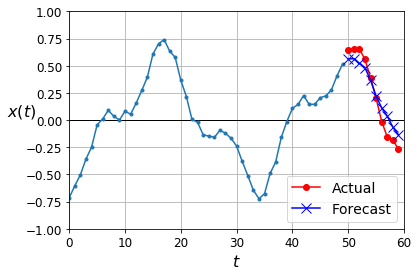

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

#### My sub-header: RNN with multiple output predictions.

Now let's create an RNN that predicts the next 10 steps at each time step. That is, instead of just forecasting time steps 50 to 59 based on time steps 0 to 49, it will forecast time steps 1 to 10 at time step 0, then time steps 2 to 11 at time step 1, and so on, and finally it will forecast time steps 50 to 59 at the last time step. Notice that the model is causal: when it makes predictions at any time step, it can only see past time steps.

In [57]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [58]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

my comment:

TimeDistributed
https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed?version=stable

This wrapper allows to apply a layer to every temporal slice of an input.

It wraps any layer (e.g. a dense layer) and applies it at every time step of its input sequence.

In [59]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 20s 3ms/sample - loss: 0.0502 - last_time_step_mse: 0.0392 - val_loss: 0.0422 - val_last_time_step_mse: 0.0309
Epoch 2/5
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0403 - last_time_step_mse: 0.0293 - val_loss: 0.0361 - val_last_time_step_mse: 0.0275
Epoch 3/5
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0409 - last_time_step_mse: 0.0343 - val_loss: 0.0393 - val_last_time_step_mse: 0.0324
Epoch 4/5
7000/7000 [==============================] - 17s 2ms/sample - loss: 0.0333 - last_time_step_mse: 0.0236 - val_loss: 0.0327 - val_last_time_step_mse: 0.0252
Epoch 5/5
7000/7000 [==============================] - 19s 3ms/sample - loss: 0.0290 - last_time_step_mse: 0.0182 - val_loss: 0.0264 - val_last_time_step_mse: 0.0150


In [39]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

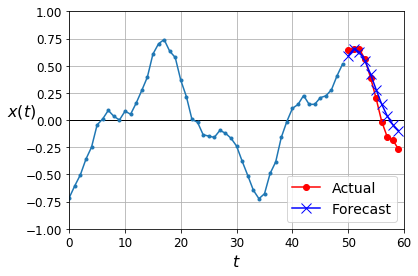

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNN with Batch Norm

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.1939 - last_time_step_mse: 0.1922 - val_loss: 0.0876 - val_last_time_step_mse: 0.0834
Epoch 2/20
7000/7000 [==============================] - 6s 840us/sample - loss: 0.0536 - last_time_step_mse: 0.0448 - val_loss: 0.0553 - val_last_time_step_mse: 0.0467
Epoch 3/20
7000/7000 [==============================] - 6s 854us/sample - loss: 0.0472 - last_time_step_mse: 0.0377 - val_loss: 0.0450 - val_last_time_step_mse: 0.0353
Epoch 4/20
7000/7000 [==============================] - 6s 843us/sample - loss: 0.0438 - last_time_step_mse: 0.0338 - val_loss: 0.0423 - val_last_time_step_mse: 0.0331
Epoch 5/20
7000/7000 [==============================] - 6s 849us/sample - loss: 0.0408 - last_time_step_mse: 0.0304 - val_loss: 0.0394 - val_last_time_step_mse: 0.0285
Epoch 6/20
7000/7000 [==============================] - 6s 835us/sample - loss: 0.0385 - last_time_step_mse: 0.027

# Deep RNNs with Layer Norm

In [42]:
from tensorflow.keras.layers import LayerNormalization

In [43]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.1636 - last_time_step_mse: 0.1493 - val_loss: 0.0725 - val_last_time_step_mse: 0.0675
Epoch 2/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0629 - last_time_step_mse: 0.0548 - val_loss: 0.0562 - val_last_time_step_mse: 0.0448
Epoch 3/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0528 - last_time_step_mse: 0.0415 - val_loss: 0.0487 - val_last_time_step_mse: 0.0357
Epoch 4/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0466 - last_time_step_mse: 0.0344 - val_loss: 0.0443 - val_last_time_step_mse: 0.0315
Epoch 5/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0428 - last_time_step_mse: 0.0306 - val_loss: 0.0408 - val_last_time_step_mse: 0.0284
Epoch 6/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0398 - last_time_step_mse: 0.0275 - 

# Creating a Custom RNN Class

In [45]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        return [tf.zeros([self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        n_steps = tf.shape(inputs)[1]
        if self.return_sequences:
            sequences = tf.TensorArray(inputs.dtype, size=n_steps)
        outputs = tf.zeros(shape=[n_steps, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return sequences.stack()
        else:
            return outputs

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 16s 2ms/sample - loss: 0.2296 - last_time_step_mse: 0.2117 - val_loss: 0.1150 - val_last_time_step_mse: 0.1047
Epoch 2/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0869 - last_time_step_mse: 0.0769 - val_loss: 0.0637 - val_last_time_step_mse: 0.0535
Epoch 3/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0562 - last_time_step_mse: 0.0452 - val_loss: 0.0514 - val_last_time_step_mse: 0.0397
Epoch 4/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0475 - last_time_step_mse: 0.0342 - val_loss: 0.0433 - val_last_time_step_mse: 0.0279
Epoch 5/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0414 - last_time_step_mse: 0.0268 - val_loss: 0.0393 - val_last_time_step_mse: 0.0244
Epoch 6/20
7000/7000 [==============================] - 13s 2ms/sample - loss: 0.0380 - last_time_step_mse: 0.0232 - 

# LSTMs

My comments:

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM?version=stable

Book: could do this as well:
keras.layers.RNN(keras.layers.LSTMCell(20), ....

However, the LSTM implementation is able to use GPUs.


In [69]:
print(X_train.shape)
print(Y_train.shape)
print("\n")
print(X_valid.shape)
print(Y_valid.shape)

(7000, 50, 1)
(7000, 50, 10)


(2000, 50, 1)
(2000, 50, 10)


In [67]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 48s 7ms/sample - loss: 0.0766 - last_time_step_mse: 0.0628 - val_loss: 0.0555 - val_last_time_step_mse: 0.0371
Epoch 2/20
7000/7000 [==============================] - 40s 6ms/sample - loss: 0.0480 - last_time_step_mse: 0.0284 - val_loss: 0.0426 - val_last_time_step_mse: 0.0223
Epoch 3/20
7000/7000 [==============================] - 43s 6ms/sample - loss: 0.0391 - last_time_step_mse: 0.0186 - val_loss: 0.0375 - val_last_time_step_mse: 0.0173
Epoch 4/20
7000/7000 [==============================] - 38s 5ms/sample - loss: 0.0352 - last_time_step_mse: 0.0154 - val_loss: 0.0334 - val_last_time_step_mse: 0.0133
Epoch 5/20
7000/7000 [==============================] - 39s 6ms/sample - loss: 0.0327 - last_time_step_mse: 0.0134 - val_loss: 0.0316 - val_last_time_step_mse: 0.0124
Epoch 6/20
7000/7000 [==============================] - 39s 6ms/sample - loss: 0.0311 - last_time_step_mse: 0.0125 - 

In [48]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 2s 753us/sample - loss: 0.0237 - last_time_step_mse: 0.0085


[0.023689542233943938, 0.008518972]

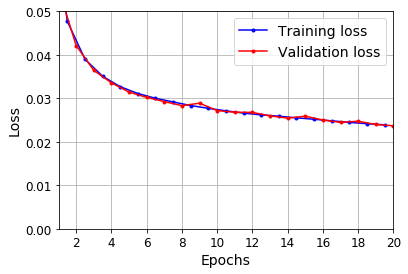

In [49]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [50]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

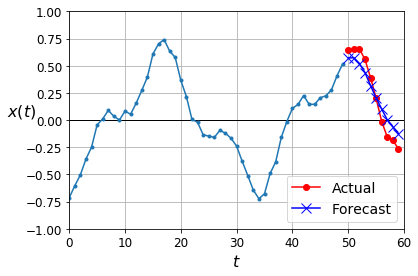

In [51]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRUs

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 21s 3ms/sample - loss: 0.0742 - last_time_step_mse: 0.0667 - val_loss: 0.0528 - val_last_time_step_mse: 0.0414
Epoch 2/20
7000/7000 [==============================] - 15s 2ms/sample - loss: 0.0476 - last_time_step_mse: 0.0365 - val_loss: 0.0440 - val_last_time_step_mse: 0.0326
Epoch 3/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0418 - last_time_step_mse: 0.0303 - val_loss: 0.0394 - val_last_time_step_mse: 0.0271
Epoch 4/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0373 - last_time_step_mse: 0.0249 - val_loss: 0.0359 - val_last_time_step_mse: 0.0226
Epoch 5/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0328 - last_time_step_mse: 0.0181 - val_loss: 0.0316 - val_last_time_step_mse: 0.0168
Epoch 6/20
7000/7000 [==============================] - 14s 2ms/sample - loss: 0.0308 - last_time_step_mse: 0.0157 - 

In [53]:
model.evaluate(X_valid, Y_valid)

2000/2000 [==============================] - 2s 777us/sample - loss: 0.0246 - last_time_step_mse: 0.0111


[0.024557730346918105, 0.011060879]

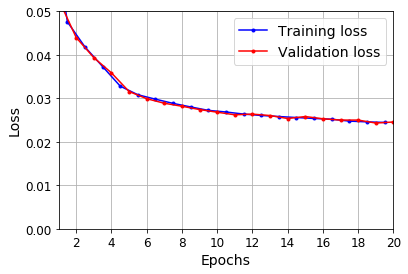

In [54]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [55]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

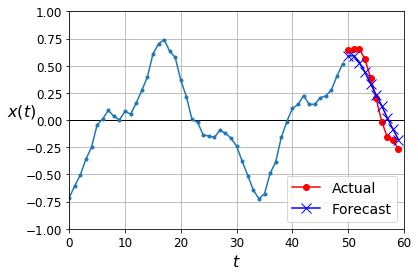

In [56]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## Using One-Dimensional Convolutional Layers to Process Sequences

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0681 - last_time_step_mse: 0.0608 - val_loss: 0.0477 - val_last_time_step_mse: 0.0397
Epoch 2/20
7000/7000 [==============================] - 7s 962us/sample - loss: 0.0411 - last_time_step_mse: 0.0338 - val_loss: 0.0367 - val_last_time_step_mse: 0.0287
Epoch 3/20
7000/7000 [==============================] - 7s 966us/sample - loss: 0.0339 - last_time_step_mse: 0.0259 - val_loss: 0.0310 - val_last_time_step_mse: 0.0217
Epoch 4/20
7000/7000 [==============================] - 7s 941us/sample - loss: 0.0284 - last_time_step_mse: 0.0186 - val_loss: 0.0260 - val_last_time_step_mse: 0.0151
Epoch 5/20
7000/7000 [==============================] - 7s 943us/sample - loss: 0.0248 - last_time_step_mse: 0.0140 - val_loss: 0.0243 - val_last_time_step_mse: 0.0137
Epoch 6/20
7000/7000 [==============================] - 6s 928us/sample - loss: 0.0234 - last_time_step_mse: 0.012

## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 451us/sample - loss: 0.0668 - last_time_step_mse: 0.0546 - val_loss: 0.0376 - val_last_time_step_mse: 0.0249
Epoch 2/20
7000/7000 [==============================] - 2s 302us/sample - loss: 0.0325 - last_time_step_mse: 0.0202 - val_loss: 0.0296 - val_last_time_step_mse: 0.0175
Epoch 3/20
7000/7000 [==============================] - 2s 286us/sample - loss: 0.0284 - last_time_step_mse: 0.0170 - val_loss: 0.0269 - val_last_time_step_mse: 0.0153
Epoch 4/20
7000/7000 [==============================] - 2s 305us/sample - loss: 0.0264 - last_time_step_mse: 0.0149 - val_loss: 0.0256 - val_last_time_step_mse: 0.0138
Epoch 5/20
7000/7000 [==============================] - 2s 303us/sample - loss: 0.0251 - last_time_step_mse: 0.0135 - val_loss: 0.0244 - val_last_time_step_mse: 0.0128
Epoch 6/20
7000/7000 [==============================] - 2s 301us/sample - loss: 0.0244 - last_time_step_mse: 0.0

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [59]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [60]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [61]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [62]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Train on 7000 samples, validate on 2000 samples
Epoch 1/2
7000/7000 [==============================] - 4s 546us/sample - loss: 0.1300 - last_time_step_mse: 0.1261 - val_loss: 0.1230 - val_last_time_step_mse: 0.1200
Epoch 2/2
7000/7000 [==============================] - 3s 410us/sample - loss: 0.1222 - last_time_step_mse: 0.1178 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189


In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs. In the next chapter we will use RNNs for Natural Language Processing, and we will learn more about RNNs (bidirectional RNNs, stateful vs stateless RNNs, Encoder–Decoders, and Attention-augmented Encoder-Decoders). We will also look at the Transformer, an Attention-only architecture.

# Exercise solutions

## 1. to 6.

See Appendix A.

## 7. Embedded Reber Grammars

First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [63]:
np.random.seed(42)

default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Let's generate a few strings based on the default Reber grammar:

In [64]:
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Looks good. Now let's generate a few strings based on the embedded Reber grammar:

In [65]:
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE BPBTSSSSSXXTTVPXVPXTTTVVEPE BPBTSSXXTVPSEPE BPBPTTTTTTTVPSEPE BTBTSXSETE BPBPTVPXVVEPE BPBPVVEPE BPBPTVVEPE BTBPTTVPXTTVPSETE BTBTSSXSETE BTBTXXTTVVETE BPBTSXSEPE BPBPTVPSEPE BTBPVVETE BPBTXXTTTVPXTVVEPE BPBPTTVPXTVVEPE BTBPVVETE BPBPTVPXVPXTVVEPE BTBPVVETE BPBTSXSEPE 

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [66]:
def generate_corrupted_string(grammar, chars="BEPSTVX"):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Let's look at a few corrupted strings:

In [67]:
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTTTXXVVETE BPBTXXSPXTVVEPE BTBTXSPTE BPTTSXXTVPXVVEPE PPBPVPSEPE BTBPTVETE BPTTSSSSSXSEPE BPBSVPSEPE BTBPVVESE BPBTXSEPS BEBTXSETE XPBTXXTVPSEPE BTBPVVEPE BTXPTVVETE BTBPVXETE BVBTXSETE BPTTXXVPXVPSEPE BTBPXVPSETE STBPTTVPXVPXTVPSETE BPBPTVPSESE BPBPVEEPE ETBTXSETE BTBTXSVTE BPBTXXVPSEPP BTBTXXVPSETS 

To be continued...